
--- 訓練モード実行中 ---
1エポック目
  平均クロスエントロピー誤差: 2.222636530925478
  学習データに対する正答率: 0.19501666666666662
  テストデータに対する正答率: 0.1144
2エポック目
  平均クロスエントロピー誤差: 2.1681953027848326
  学習データに対する正答率: 0.1648500000000002
  テストデータに対する正答率: 0.1783
3エポック目
  平均クロスエントロピー誤差: 2.1643428395404887
  学習データに対する正答率: 0.17436666666666678
  テストデータに対する正答率: 0.1263
4エポック目
  平均クロスエントロピー誤差: 2.2240367302014206
  学習データに対する正答率: 0.14828333333333338
  テストデータに対する正答率: 0.1305
5エポック目
  平均クロスエントロピー誤差: 2.170908706336664
  学習データに対する正答率: 0.16576666666666676
  テストデータに対する正答率: 0.1603
6エポック目
  平均クロスエントロピー誤差: 2.1628996557856617
  学習データに対する正答率: 0.16756666666666686
  テストデータに対する正答率: 0.1801
7エポック目
  平均クロスエントロピー誤差: 2.2284163704154696
  学習データに対する正答率: 0.14333333333333323
  テストデータに対する正答率: 0.1379
8エポック目
  平均クロスエントロピー誤差: 2.2024635056093977
  学習データに対する正答率: 0.1522999999999999
  テストデータに対する正答率: 0.1467
9エポック目
  平均クロスエントロピー誤差: 2.1852984739586616
  学習データに対する正答率: 0.1584333333333334
  テストデータに対する正答率: 0.1625
10エポック目
  平均クロスエントロピー誤差: 2.155890755351449
  学習データに対する正答率: 0

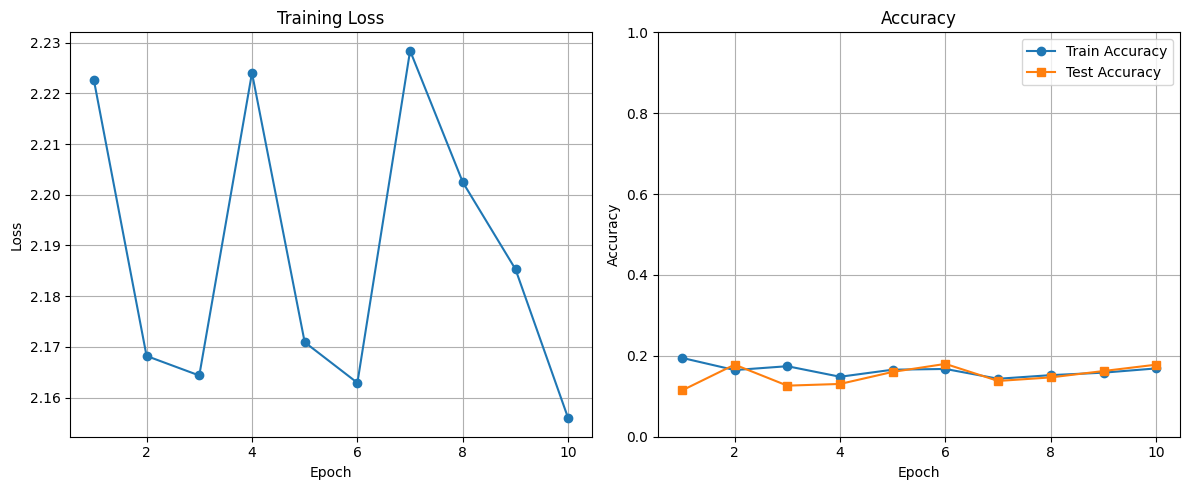

In [6]:
import numpy as np 
import mnist 
import matplotlib.pyplot as plt
import gzip
# import sys

# ローカルMNISTデータの読み込み
train_images = mnist.parse_idx(gzip.open("all/mnist_data/train-images-idx3-ubyte.gz", "rb"))
train_labels = mnist.parse_idx(gzip.open("all/mnist_data/train-labels-idx1-ubyte.gz", "rb"))
test_images  = mnist.parse_idx(gzip.open("all/mnist_data/t10k-images-idx3-ubyte.gz", "rb"))
test_labels  = mnist.parse_idx(gzip.open("all/mnist_data/t10k-labels-idx1-ubyte.gz", "rb"))


# # --- ユーザー入力と前処理 ---
# def get_input_image_vector():
#     # ユーザーから画像番号を入力させ、対応する画像ベクトルを返す
#     try:
#         image_number = int(input("0~9999までの整数を入力してください："))
#         if not (0 <= image_number <= 9999):
#             print("無効な数値です。")
#             sys.exit()
 
#         # 28x28の画像を1次元ベクトルに変換
#         return train_images[image_number].reshape(-1)
#     except ValueError:
#         print("無効な入力です。整数を入力してください。")
#         sys.exit()

# def get_random_index(batch_size): #インデックスをランダムに取得
#     # np.arrangeの生成を省略し、直接データ数からサンプリングする
#     return np.random.choice(len(train_images), size=batch_size, replace=False)

def get_shuffled_index(arr):
    index_arr = np.arange(len(arr)) # 0から始まるインデックスの配列を作成
    np.random.shuffle(index_arr) # インデックスをシャッフル
    return index_arr

# 画像とラベルを別々に取得する冗長な関数を一つに統合
def get_batch(random_index): 
    # ベクトルとラベルをまとめて取得
    batch_images = train_images[random_index].reshape(len(random_index), -1) # 画像データを (バッチサイズ, 784) の2次元配列に変換
    batch_labels = train_labels[random_index]
    return batch_images, batch_labels

def get_one_hot_label(batch_labels, output_layer_size):
    one_hot_labels = np.zeros((batch_labels.size, output_layer_size)) # ゼロで満たされた配列を作成
    one_hot_labels[np.arange(batch_labels.size), batch_labels] = 1 # 各行の、正解ラベルに対応するインデックスを1にする
    return one_hot_labels


np.random.seed(777) # シードを固定

# レイヤーの次元数を定義
input_size = train_images[0].size  # 入力層: 784 (28*28)
hidden_layer_size = 100 # 中間層: 100ユニット
output_layer_size = 10  # 出力層: 10ユニット (0-9の数字に対応)

# 重みとバイアスを正規分布で初期化

is_load = str(input('ロードしますか？ yes or no:  '))
if is_load == 'yes' :
    loaded_data = np.load('assignment3_parameter.npz')
    weight1 = loaded_data['weight1']
    bias1 = loaded_data['bias1']
    weight2 = loaded_data['weight2']
    bias2 = loaded_data['bias2']
else:
    # 第1層（入力層 -> 中間層）
    weight1 = np.random.normal(loc=0.0, scale=np.sqrt(1 / input_size), size=(hidden_layer_size, input_size)) # weight1: (100, 784) 784個の入力それぞれに対する、100個の中間層ユニットの重み
    bias1 = np.random.normal(loc=0.0, scale=np.sqrt(1 / input_size), size=hidden_layer_size) # bias1: (100,) 100個の中間層ユニットのバイアス

    # 第2層（中間層 -> 出力層）
    weight2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=(output_layer_size, hidden_layer_size)) # weight2: (10, 100) 100個の中間層ユニットそれぞれに対する、10個の出力層ユニットの重み
    bias2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / hidden_layer_size), size=output_layer_size) # bias2: (10,) 10個の出力層ユニットのバイアス

# --- 活性化関数と出力関数 ---
# def sigmoid(x):
#     """シグモイド活性化関数"""
#     return 1 / (1 + np.exp(-x))

def ReLU(arr):
    """課題4-1 ReLU活性化関数"""
    new_arr = np.where(arr > 0, arr, 0)
    return new_arr

def softmax(x):
    """
    ソフトマックス関数（オーバーフロー対策版）
    各要素を0から1の間の確率に変換
    """
    alpha = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - alpha)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# --- 順伝播の実行(重みを更新) ---
def forward_propagation(input_vector, weight1, bias1, weight2, bias2):
    
    # 中間層の計算: 活性化関数の入力　 (バッチサイズ, 784) @ (784, 100) -> (バッチサイズ, 100)
    hidden_layer_input = np.dot(input_vector, weight1.T) + bias1
    
    # 中間層の出力: 活性化関数を適用
    # hidden_layer_output = sigmoid(hidden_layer_input)
    hidden_layer_output = ReLU(hidden_layer_input)
    
    # 出力層の計算: 活性化関数の入力　(バッチサイズ, 100) @ (100, 10) -> (バッチサイズ, 10)
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    
    # 出力層の出力: ソフトマックスを適用して確率を算出
    final_output = softmax(output_layer_input)
    
    return final_output, hidden_layer_input, hidden_layer_output # 4-1 hidden_layer_inputを出力に追加

def forward_propagation_train(input_vector, weight1, bias1, weight2, bias2, ignore_number):
    
    hidden_layer_input = np.dot(input_vector, weight1.T) + bias1
    hidden_layer_output = ReLU(hidden_layer_input)
    for index in ignore_number:
        hidden_layer_output[:, index] = 0
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    return final_output, hidden_layer_input, hidden_layer_output  

def forward_propagation_test(input_vector, weight1, bias1, weight2, bias2, ignore_number):
    
    hidden_layer_input = np.dot(input_vector, weight1.T) + bias1
    hidden_layer_output = ReLU(hidden_layer_input)
    hidden_layer_output *= 1 - (len(ignore_number) / hidden_layer_size)
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    return final_output, hidden_layer_input, hidden_layer_output 

def get_predicted_class(output_probabilities):
 # 出力された確率から最も高い確率を持つクラス（予測結果）を取得
    if output_probabilities.ndim == 1:
        return np.argmax(output_probabilities)
    else:
        return np.argmax(output_probabilities, axis=1)

def get_cross_entropy_error(y_pred, y_true):
    
    delta = 1e-7
    
    loss = -np.sum(y_true * np.log(y_pred + delta)) # logの中身が0にならないようにdeltaを導入
    
    # ミニバッチサイズBで割って平均を求める
    batch_size = y_pred.shape[0]
    
    cross_entropy_error = loss / batch_size
    
    return cross_entropy_error

def backward_propagation_and_update(batch_image_vector, hidden_layer_input, hidden_layer_output, output_probabilities, one_hot_labels, 
                                    weight1, bias1, weight2, bias2, learning_rate):
    """
    逆伝播法を用いて勾配を計算し、全パラメータを更新する関数。
    更新後のパラメータを返す。 4-1 ReLUにより、hidden_layer_inputも受け取る。
    """
    current_batch_size = batch_image_vector.shape[0]
    
    # --- 逆伝播 ---
    dEn_dak = (output_probabilities - one_hot_labels) / current_batch_size
    dEn_dX = np.dot(dEn_dak, weight2)
    dEn_dW_1 = np.dot(dEn_dak.T, hidden_layer_output)
    dEn_db_1 = np.sum(dEn_dak, axis = 0)
    # dEn_dX_sig = dEn_dX * (hidden_layer_output * (1 - hidden_layer_output))
    differentiated_input = np.where(hidden_layer_input > 0, 1, 0) # ReLUに入力するhidden_input_layerの微分
    dEn_dX_sig = dEn_dX * differentiated_input
    
    dEn_dW_2= np.dot(dEn_dX_sig.T, batch_image_vector)
    dEn_db_2 = np.sum(dEn_dX_sig, axis=0)

    # --- パラメータ更新 ---
    weight1 -= dEn_dW_2 * learning_rate 
    bias1   -= dEn_db_2 * learning_rate
    weight2 -= dEn_dW_1 * learning_rate 
    bias2   -= dEn_db_1 * learning_rate
    
    return weight1, bias1, weight2, bias2

def backward_propagation_and_update_train(batch_image_vector, hidden_layer_input, hidden_layer_output, output_probabilities, one_hot_labels, 
                                    weight1, bias1, weight2, bias2, learning_rate, ignore_number, momentum, prev_delta_W1, prev_delta_W2):
    current_batch_size = batch_image_vector.shape[0]
    dEn_dak = (output_probabilities - one_hot_labels) / current_batch_size
    dEn_dX = np.dot(dEn_dak, weight2)
    dEn_dW_1 = np.dot(dEn_dak.T, hidden_layer_output)
    dEn_db_1 = np.sum(dEn_dak, axis = 0)
    # dEn_dX_sig = dEn_dX * (hidden_layer_output * (1 - hidden_layer_output))
    differentiated_input = np.where(hidden_layer_input > 0, 1, 0) # ReLUに入力するhidden_input_layerの微分
    for index in ignore_number:
        dEn_dX[:, index] = 0 
        differentiated_input[:, index] = 0 
    dEn_dX_sig = dEn_dX * differentiated_input 
    dEn_dW_2= np.dot(dEn_dX_sig.T, batch_image_vector)
    dEn_db_2 = np.sum(dEn_dX_sig, axis=0)
    weight1 += (momentum * prev_delta_W1 - dEn_dW_2 * learning_rate )
    bias1   -= dEn_db_2 * learning_rate
    weight2 += (momentum * prev_delta_W2 - dEn_dW_1 * learning_rate )
    bias2   -= dEn_db_1 * learning_rate
    
    params_delta_W1 = - dEn_dW_2 * learning_rate
    params_delta_W2 = - dEn_dW_1 * learning_rate
    return weight1, bias1, weight2, bias2, params_delta_W1, params_delta_W2

def get_accuracy(y_prop, y_true): # 正答率計算

    y_pred = get_predicted_class(y_prop) # 予測結果

    accuracy = np.sum(y_pred == y_true) / len(y_prop)

    return accuracy

def calculate_accuracy_for_epoch(images, labels, weight1, bias1, weight2, bias2, mode, ignore_number):
    """
    指定されたデータセットに対するモデルの正答率を計算する関数。
    modeに応じてforward_propagation_train/testを呼び出す。
    """
    images_vector = images.reshape(len(images), -1)

    if mode == 'train':

        probabilities, _, _ = forward_propagation_train(images_vector, weight1, bias1, weight2, bias2, ignore_number)
    elif mode == 'test':
        probabilities, _, _ = forward_propagation_test(images_vector, weight1, bias1, weight2, bias2, ignore_number)
    else:
         # デフォルト
        probabilities, _, _ = forward_propagation(images_vector, weight1, bias1, weight2, bias2)

    accuracy = get_accuracy(probabilities, labels)

    return accuracy

# --- メイン処理 ---
if __name__ == "__main__":

    batch_size = 100
    epoch_number = 10
    learning_rate = 0.01
    train_loss_list, train_acc_list, test_acc_list = [], [], []
    momentum = 0.9

    while True:
        mode = str(input('実行モードを入力してください (train or test): '))
        if mode in ['train', 'test']:
            break
        print("無効なモードです。'train' または 'test' を入力してください。")

    while True:
        try:
            ignore_number = int(input(f'Dropoutの個数を 0 ~ {hidden_layer_size} で入力してください: '))
            if 0 <= ignore_number <= hidden_layer_size:
                break
            else:
                print(f"無効なドロップアウト数です。0から{hidden_layer_size}の範囲で入力してください。")
        except ValueError:
            print("無効な入力です。整数を入力してください。")

    # 訓練モードの場合にのみ学習を実行
    if mode == 'train':
        print("\n--- 訓練モード実行中 ---")

        for i in range(1, epoch_number + 1):
            error_sum = 0
            train_accuracy_sum = 0
            shuffled_train_image_index = get_shuffled_index(train_images)
            prev_delta_W1 = 0
            prev_delta_W2 = 0
            
            for j in range(0, len(shuffled_train_image_index), batch_size): # range(start, stop, step) を使い、batch_sizeずつインデックスをずらしながらループ

                # hidden_layer_size分のインデックス配列からignore_number個ランダムに選択
                random_selection = np.random.choice(np.arange(hidden_layer_size), size=ignore_number, replace=False)
                
                index = shuffled_train_image_index[j:j + batch_size]    #シャッフルしたインデックスから、先頭のbatch_size分取り出す

                # 統合した関数を使い、ミニバッチと対応ラベルを一度に取得
                batch_image_vector, batch_labels = get_batch(index)

                # 順伝播を実行 4-1 hidden_layer_inputを出力し、ReLUに使用
                output_probabilities, hidden_layer_input, hidden_layer_output = forward_propagation_train(
                    batch_image_vector, weight1, bias1, weight2, bias2, random_selection
                )
                # one-hot labelsを取得
                one_hot_labels = get_one_hot_label(batch_labels, output_layer_size)

                
                # クロスエントロピー誤差平均を計算
                calculated_error = get_cross_entropy_error(output_probabilities, one_hot_labels)
                error_sum += calculated_error
                # --- 逆伝播 ---
                weight1, bias1, weight2, bias2, prev_delta_W1, prev_delta_W2 = backward_propagation_and_update_train(
                    batch_image_vector, hidden_layer_input, hidden_layer_output, output_probabilities, one_hot_labels,
                    weight1, bias1, weight2, bias2, learning_rate, random_selection, momentum, prev_delta_W1, prev_delta_W2
                )
                train_accuracy_sum += calculate_accuracy_for_epoch(batch_image_vector, batch_labels, weight1, bias1, weight2, bias2, 'train', random_selection)

            ignore_index_for_acc = np.arange(hidden_layer_size)[:ignore_number] 
            test_accuracy = calculate_accuracy_for_epoch(test_images, test_labels, weight1, bias1, weight2, bias2, 'test', ignore_index_for_acc)
        
            num_batches = len(train_images) // batch_size
            train_loss_list.append(error_sum / num_batches)
            train_acc_list.append(train_accuracy_sum/ num_batches)
            test_acc_list.append(test_accuracy)
            print(f"{i}エポック目")
            print(f"  平均クロスエントロピー誤差: {error_sum / num_batches}")
            print(f"  学習データに対する正答率: {train_accuracy_sum / num_batches}")
            print(f"  テストデータに対する正答率: {test_accuracy}")
        
    # --- グラフの描画 ---
        x = np.arange(1, epoch_number + 1)
        plt.figure(figsize=(12, 5))

        # 誤差のグラフ
        plt.subplot(1, 2, 1)
        plt.plot(x, train_loss_list, marker='o')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # 正答率のグラフ
        plt.subplot(1, 2, 2)
        plt.plot(x, train_acc_list, marker='o', label='Train Accuracy')
        plt.plot(x, test_acc_list, marker='s', label='Test Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0)
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
        np.savez('assignment3_parameter.npz', weight1 = weight1, bias1 = bias1, weight2 = weight2, bias2 = bias2)
    # テストモードの場合にのみ予測を実行
    elif mode == 'test':
        print("\n--- テストモード実行中 ---")
        random_selection = np.random.choice(np.arange(hidden_layer_size), size=ignore_number, replace=False)
    # テストデータに対する最終的な正答率を計算
        test_accuracy = calculate_accuracy_for_epoch(test_images, test_labels, weight1, bias1, weight2, bias2, 'test', random_selection)

        print(f"\nテストデータに対する最終正答率: {test_accuracy}")
        print(f"（ドロップアウト数 {ignore_number} 個）")